In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv("TTLCON.csv", parse_dates=True, index_col="DATE")
df.index.freq="MS"

In [3]:
df.describe()

,TTLCON
count,120.000000
mean,88216.833333
std,19533.130602
min,50973.000000
25%,73332.250000
50%,86840.500000
75%,106361.750000
max,122010.000000


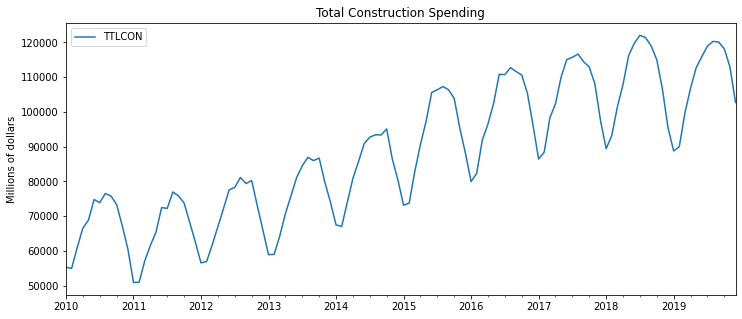

In [5]:
ax = df.plot(figsize=(12,5))
plt.title("Total Construction Spending")
plt.ylabel("Millions of dollars")
plt.xlabel("")
plt.show()

Check if the data are stationary

In [6]:
adfuller(df.TTLCON)

(-1.0060633845743006,
 0.7510464016810172,
 13,
 106,
 {'1%': -3.4936021509366793,
  '5%': -2.8892174239808703,
  '10%': -2.58153320754717},
 1852.3576355439993)

In [7]:
adfuller(df.TTLCON.diff(1).dropna())

(-2.642896744021171,
 0.08445145458921421,
 12,
 106,
 {'1%': -3.4936021509366793,
  '5%': -2.8892174239808703,
  '10%': -2.58153320754717},
 1835.3207631252785)

In [8]:
adfuller(df.TTLCON.diff(2).dropna())

(-3.2109969822637976,
 0.01935689015691865,
 13,
 104,
 {'1%': -3.4948504603223145,
  '5%': -2.889758398668639,
  '10%': -2.5818220155325444},
 1814.0888303127529)

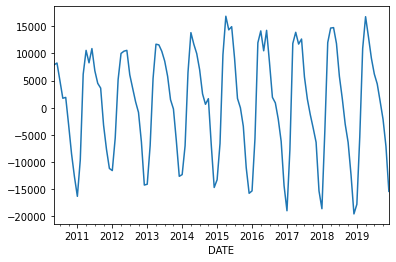

In [14]:
df['d2'] = df.TTLCON.diff(2)
df.dropna(inplace=True)
df.d2.plot();

/home/sqauess/Documents/University/TimeSeries/venv/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


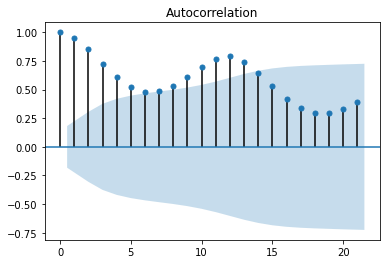

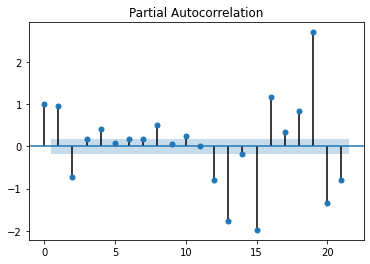

In [16]:
plot_acf(df.TTLCON);
plot_pacf(df.TTLCON);

/home/sqauess/Documents/University/TimeSeries/venv/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


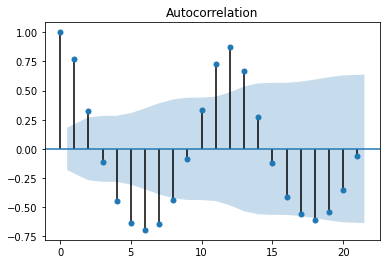

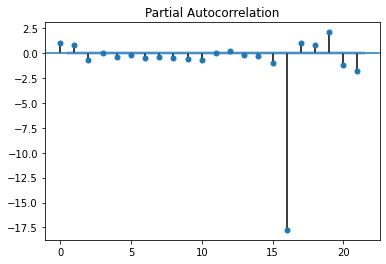

In [17]:
plot_acf(df.d2);
plot_pacf(df.d2);

Check for the seasonality

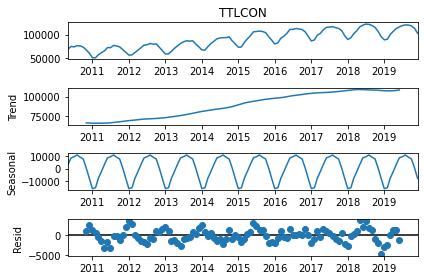

In [18]:
res_season = seasonal_decompose(df.TTLCON)
res_season.plot();

In [19]:
def evaluate_model(model, start, test, model_name, **kwargs):
    """ Function to evaluate predictions against test set.
    
    Args:
        model: model to produce predictions
        start: start index of prediction usually len(train)
        test: test data
        model_name: name to rename the model data
        **kwargs: additional parameters for predict function
        
    Returns:
        predictions
    """
    predictions = model.predict(start=start, end=start+len(test)-1, dynamic=False, **kwargs).rename(model_name)
    print(f"MSE for {model_name}: \t{mean_squared_error(test, predictions)}")
    print(f"RMSE for {model_name}: \t{rmse(test, predictions)}")
    return predictions

In [20]:
def plot_results(test, predictions):
    """ Plots the predicted data and test data to visualise the predictions.
    
    Args:
        test: test data
        prediction: predictions data
    """
    title = "Compare prediction with test set"
    xlabel = "date"
    ylabel="Millions of units"
    
    ax = test.plot(legend=True, figsize=(12,6), title=title, label="Test data")
    predictions.plot(legend=True)
    ax.autoscale(axis="x", tight=True)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    plt.show()

Do not specify any parameters

In [21]:
stepwise = auto_arima(
    df.TTLCON,
    m=12,
    d=None,
    D=None,
    start_p=1,
    start_q=1,
    max_p=4,
    max_d=4,
    max_q=4,
    max_P=4,
    max_D=4,
    max_Q=4,
    stepwise=False,
    trace=True,
    n_jobs=-1
)
stepwise.summary()

Total fit time: 100.280 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  116
Model:             SARIMAX(0, 0, 1)x(2, 1, [1, 2], 12)   Log Likelihood                -979.254
Date:                                 Sun, 14 Jun 2020   AIC                           1972.509
Time:                                         22:39:38   BIC                           1991.019
Sample:                                              0   HQIC                          1980.008
                                                 - 116                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5044.7942   1242.834      4.059      0.000    2608.885    7480.704
ma.L1          0.1464      0.051      2.879      0.004       0.047       0.246
ar.S.L12       1.0567      0.134      7.861      0.000       0.793       1.320
ar.S.L24      -0.8850      0.144     -6.149      0.000      -1.167      -0.603
ma.S.L12      -1.1668      0.160     -7.276      0.000      -1.481      -0.852
ma.S.L24       0.9540      0.232      4.117      0.000       0.500       1.408
sigma2      1.319e+07      0.017   7.55e+08      0.000    1.32e+07    1.32e+07
===================================================================================
Ljung-Box (Q):                      193.79   Jarque-Bera (JB):                34.11
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                            -0.97
Prob(H) (two-sided):                  0.31   Kurtosis:                         5.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.43e+26. Standard errors may be unstable.
"""

Set $d=2$

In [22]:
stepwise = auto_arima(
    df.TTLCON,
    m=12,
    d=2,
    D=None,
    start_p=1,
    start_q=1,
    max_p=4,
    max_q=4,
    max_P=4,
    max_D=4,
    max_Q=4,
    stepwise=False,
    trace=True,
    n_jobs=-1
)
stepwise.summary()

Total fit time: 83.841 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  116
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 12)   Log Likelihood                -915.768
Date:                            Sun, 14 Jun 2020   AIC                           1843.537
Time:                                    22:41:02   BIC                           1859.287
Sample:                                         0   HQIC                          1849.914
                                            - 116                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.9294      4.461      1.105      0.269      -3.813      13.672
ar.L1          0.5930      0.076      7.854      0.000       0.445       0.741
ma.L1         -0.8864      0.072    -12.373      0.000      -1.027      -0.746
ar.S.L12       0.7608      0.081      9.412      0.000       0.602       0.919
ma.S.L12      -0.9998      0.172     -5.803      0.000      -1.337      -0.662
sigma2      3.322e+06   6.92e-08    4.8e+13      0.000    3.32e+06    3.32e+06
===================================================================================
Ljung-Box (Q):                      255.68   Jarque-Bera (JB):                 2.16
Prob(Q):                              0.00   Prob(JB):                         0.34
Heteroskedasticity (H):               1.07   Skew:                            -0.27
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.26e+31. Standard errors may be unstable.
"""

set $d=1$

In [23]:
stepwise = auto_arima(
    df.TTLCON,
    m=12,
    d=1,
    D=None,
    start_p=1,
    start_q=1,
    max_p=4,
    max_q=4,
    max_P=4,
    max_D=4,
    max_Q=4,
    stepwise=False,
    trace=True,
    n_jobs=-1
)
stepwise.summary()

Total fit time: 64.049 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  116
Model:             SARIMAX(2, 1, 3)x(0, 1, [], 12)   Log Likelihood                -897.390
Date:                             Sun, 14 Jun 2020   AIC                           1808.780
Time:                                     22:42:06   BIC                           1827.223
Sample:                                          0   HQIC                          1816.250
                                             - 116                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     16.1788    474.308      0.034      0.973    -913.448     945.806
ar.L1         -1.1264      0.020    -57.191      0.000      -1.165      -1.088
ar.L2         -0.9995      0.005   -212.532      0.000      -1.009      -0.990
ma.L1          1.1121      0.098     11.327      0.000       0.920       1.305
ma.L2          0.9779      0.147      6.643      0.000       0.689       1.266
ma.L3         -0.0190      0.069     -0.276      0.783      -0.154       0.116
sigma2      2.203e+06      0.002   1.01e+09      0.000     2.2e+06     2.2e+06
===================================================================================
Ljung-Box (Q):                       73.03   Jarque-Bera (JB):                 0.03
Prob(Q):                              0.00   Prob(JB):                         0.98
Heteroskedasticity (H):               1.54   Skew:                            -0.00
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+27. Standard errors may be unstable.
"""

set $d=1$ and $D=1$

In [24]:
stepwise = auto_arima(
    df.TTLCON,
    m=12,
    d=1,
    D=1,
    start_p=1,
    start_q=1,
    max_p=4,
    max_q=4,
    max_P=4,
    max_Q=4,
    stepwise=False,
    trace=True,
    n_jobs=-1
)
stepwise.summary()

Total fit time: 65.529 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  116
Model:             SARIMAX(2, 1, 3)x(0, 1, [], 12)   Log Likelihood                -897.390
Date:                             Sun, 14 Jun 2020   AIC                           1808.780
Time:                                     22:43:12   BIC                           1827.223
Sample:                                          0   HQIC                          1816.250
                                             - 116                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     16.1788    474.308      0.034      0.973    -913.448     945.806
ar.L1         -1.1264      0.020    -57.191      0.000      -1.165      -1.088
ar.L2         -0.9995      0.005   -212.532      0.000      -1.009      -0.990
ma.L1          1.1121      0.098     11.327      0.000       0.920       1.305
ma.L2          0.9779      0.147      6.643      0.000       0.689       1.266
ma.L3         -0.0190      0.069     -0.276      0.783      -0.154       0.116
sigma2      2.203e+06      0.002   1.01e+09      0.000     2.2e+06     2.2e+06
===================================================================================
Ljung-Box (Q):                       73.03   Jarque-Bera (JB):                 0.03
Prob(Q):                              0.00   Prob(JB):                         0.98
Heteroskedasticity (H):               1.54   Skew:                            -0.00
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+27. Standard errors may be unstable.
"""

In [25]:
s_index = -12
train = df.iloc[:s_index]
test = df.iloc[s_index:]

Create all the SARIMAX models

In [29]:
sarimax_1 = SARIMAX(train.TTLCON, order=(0, 0, 1), seasonal_order=(2, 1, [1, 2], 12)).fit()
sarimax_2 = SARIMAX(train.TTLCON, order=(1, 2, 1), seasonal_order=(1, 1, 1, 12)).fit()
sarimax_3 = SARIMAX(train.TTLCON, order=(2, 1, 3), seasonal_order=(0, 1, [], 12)).fit()
# additional to test
sarimax_4 = SARIMAX(train.TTLCON, order=(2,0,1), seasonal_order=(0,1,1,12)).fit()
sarimax_5 = SARIMAX(train.TTLCON, order=(2,1,1), seasonal_order=(0,1,1,12)).fit()

/home/sqauess/Documents/University/TimeSeries/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/home/sqauess/Documents/University/TimeSeries/venv/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/sqauess/Documents/University/TimeSeries/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/sqauess/Documents/University/TimeSeries/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters f

In [30]:
res_sarimax_1 = evaluate_model(sarimax_1, len(train), test.TTLCON, "(0, 0, 1)x(2, 1, [1, 2], 12)")
res_sarimax_2 = evaluate_model(sarimax_2, len(train), test.TTLCON, "(1, 2, 1)x(1, 1, 1, 12)")
res_sarimax_3 = evaluate_model(sarimax_3, len(train), test.TTLCON, "(2, 1, 3)x(0, 1, [], 12)")
res_sarimax_4 = evaluate_model(sarimax_4, len(train), test.TTLCON, "(2,0,1)x(0,1,1,12)")
res_sarimax_5 = evaluate_model(sarimax_5, len(train), test.TTLCON, "(2,1,1)x(0,1,1,12)")

MSE for (0, 0, 1)x(2, 1, [1, 2], 12): 	36409656.630913
RMSE for (0, 0, 1)x(2, 1, [1, 2], 12): 	6034.041484023208
MSE for (1, 2, 1)x(1, 1, 1, 12): 	246517961.62099406
RMSE for (1, 2, 1)x(1, 1, 1, 12): 	15700.890472230996
MSE for (2, 1, 3)x(0, 1, [], 12): 	16101919.083244847
RMSE for (2, 1, 3)x(0, 1, [], 12): 	4012.7196616814444
MSE for (2,0,1)x(0,1,1,12): 	43446948.46537794
RMSE for (2,0,1)x(0,1,1,12): 	6591.429925697302
MSE for (2,1,1)x(0,1,1,12): 	11428876.71968624
RMSE for (2,1,1)x(0,1,1,12): 	3380.6621717773337


Plot 2 best results

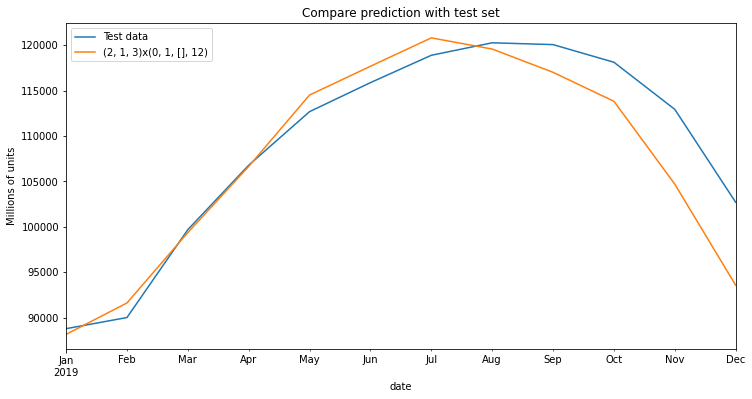

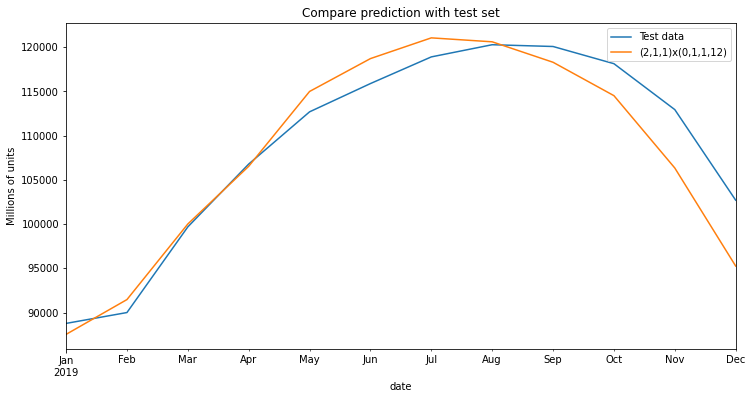

In [34]:
plot_results(test.TTLCON, res_sarimax_3)
plot_results(test.TTLCON, res_sarimax_5)

Let us check the Exponential Smoothing

In [35]:
hw_es = ExponentialSmoothing(
    train.TTLCON,
    trend='mul',
    seasonal='mul',
    seasonal_periods=12
).fit()
res_hw_es = hw_es.forecast(12).rename("Exponential Smoothing")
print(f"MSE for Exponential Smoothing: \t{mean_squared_error(test.TTLCON, res_hw_es)}")
print(f"RMSE for Exponential Smoothing: \t{rmse(test.TTLCON, res_hw_es)}")

MSE for Exponential Smoothing: 	6327353.1897783615
RMSE for Exponential Smoothing: 	2515.423063776422


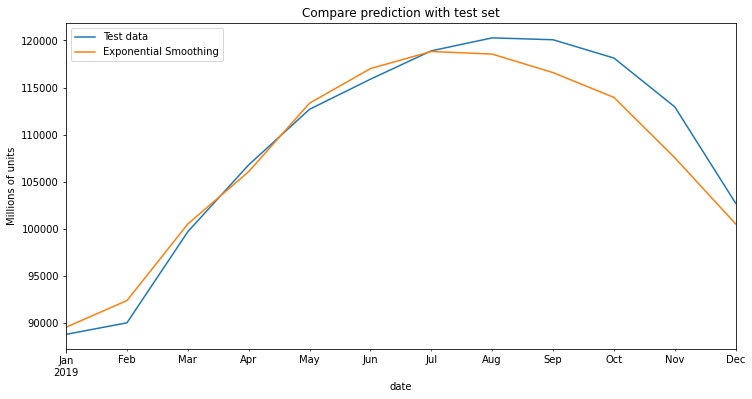

In [36]:
plot_results(test.TTLCON, res_hw_es)

Let us check the Prophet from fbprophet module

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


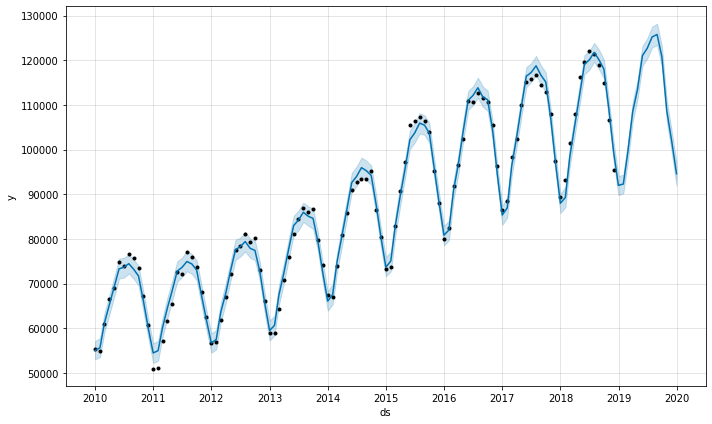

In [38]:
prop_data = pd.read_csv("TTLCON.csv", parse_dates=True)
prop_data.columns = ["ds", "y"]
prop_train = prop_data.iloc[:-12]
m = Prophet(seasonality_mode='multiplicative').fit(prop_train)
future = m.make_future_dataframe(periods=13, freq='M')
fcst = m.predict(future)
fig = m.plot(fcst)

In [39]:
fcst[["ds",'yhat']].iloc[-12:]

,ds,yhat
109,2019-01-31,92287.256960
110,2019-02-28,99409.009943
111,2019-03-31,108507.939186
112,2019-04-30,113468.256666
113,2019-05-31,121032.438876
114,2019-06-30,122677.707122
115,2019-07-31,125226.438199
116,2019-08-31,125776.792472
117,2019-09-30,120809.014583
118,2019-10-31,108628.248808


In [40]:
fcst_test = fcst.set_index("ds")


In [41]:
print(f"MSE for Prophet: \t{mean_squared_error(test.TTLCON, fcst_test['yhat'][-12:])}")
print(f"RMSE for Prophet: \t{rmse(test.TTLCON, fcst_test['yhat'][-12:])}")

MSE for Prophet: 	57048913.57835562
RMSE for Prophet: 	7553.073121475498


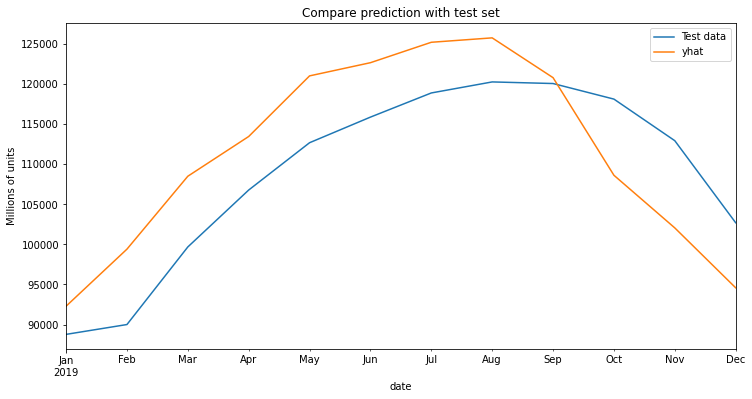

In [42]:
plot_results(test.TTLCON, fcst_test['yhat'][-12:])

Again the Exponential Smoothing gives us the smallest error, we will use this one to predict the future data.

In [43]:
hw_es = ExponentialSmoothing(
    df.TTLCON,
    trend='mul',
    seasonal='mul',
    seasonal_periods=12
).fit()
res_hw_es = hw_es.forecast(12).rename("Exponential Smoothing")

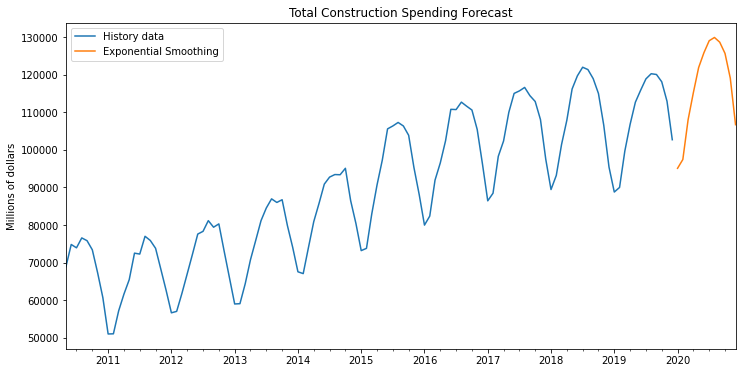

In [44]:
title = "Total Construction Spending Forecast"
ylabel = "Millions of dollars"
ax = df.TTLCON.plot(legend=True, figsize=(12,6), title=title, label="History data")
res_hw_es.plot(legend=True)
ax.autoscale(axis="x", tight=True)
ax.set(xlabel="", ylabel=ylabel)
plt.show()

Let us try RandomForest from H2o

In [45]:
import h2o
from h2o.estimators import H2ORandomForestEstimator

In [46]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.7" 2020-04-14; OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-3ubuntu1); OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-3ubuntu1, mixed mode, sharing)
  Starting server from /home/sqauess/Documents/University/TimeSeries/venv/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpva_42spc
  JVM stdout: /tmp/tmpva_42spc/h2o_sqauess_started_from_python.out
  JVM stderr: /tmp/tmpva_42spc/h2o_sqauess_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Warsaw
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.4
H2O_cluster_version_age:,13 days
H2O_cluster_name:,H2O_from_python_sqauess_vkjy44
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.887 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [50]:
df = pd.read_csv("TTLCON.csv", parse_dates=True, index_col='DATE')
df.index.freq="MS"
df.tail()

,TTLCON
DATE,
2019-08-01,120278
2019-09-01,120078
2019-10-01,118134
2019-11-01,112942
2019-12-01,102703


In [63]:
df1 = df.copy()

df1['lag1'] = df1.TTLCON.shift(1)
df1.dropna(inplace=True)

df1['lag2'] = df1.TTLCON.shift(2)
df1.dropna(inplace=True)

df1['lag12'] = df1.TTLCON.shift(12)
df1.dropna(inplace=True)

df1['d1'] = df1.TTLCON.diff(1)
df1.dropna(inplace=True)

df1['d2'] = df1.TTLCON.diff(2)
df1.dropna(inplace=True)
df1.tail()

,TTLCON,lag1,lag2,lag12,d1,d2
DATE,,,,,,
2019-08-01,120278,118902.0,115887.0,121385.0,1376.0,4391.0
2019-09-01,120078,120278.0,118902.0,118968.0,-200.0,1176.0
2019-10-01,118134,120078.0,120278.0,115002.0,-1944.0,-2144.0
2019-11-01,112942,118134.0,120078.0,106590.0,-5192.0,-7136.0
2019-12-01,102703,112942.0,118134.0,95415.0,-10239.0,-15431.0


In [64]:
train=h2o.H2OFrame(df1.iloc[:-12])
test=h2o.H2OFrame(df1.iloc[-12:])

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [66]:
x=['lag1', 'lag2', 'lag12', 'd2', 'd1']
y='TTLCON'
model = H2ORandomForestEstimator(ntrees=100, max_depth=30, nfolds=15)
model.train(x=x, y=y, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [67]:
performance = model.model_performance(test_data=test)
print(performance)


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 15497732.252277084
RMSE: 3936.7159222221107
MAE: 2572.877083333334
RMSLE: 0.03896676002131595
Mean Residual Deviance: 15497732.252277084



RMSE is worse than the Exponential Smoothing

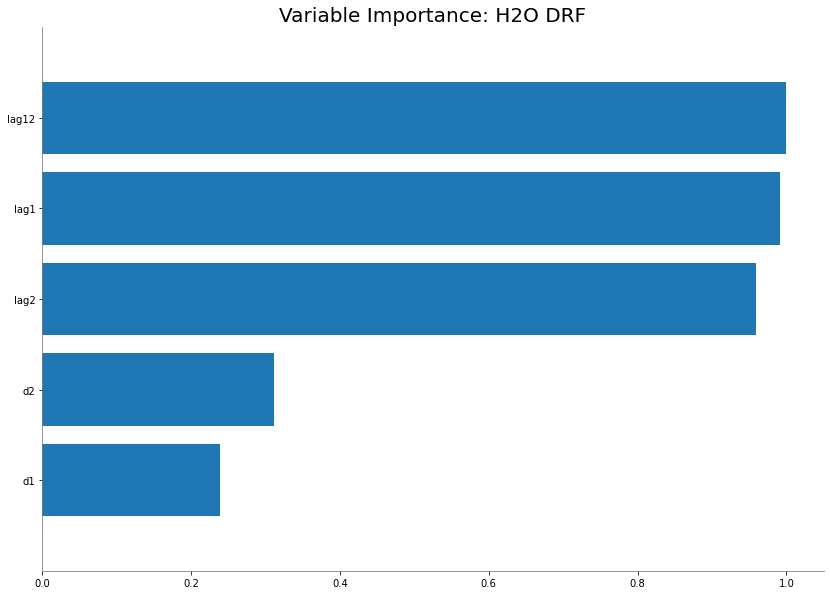

In [68]:
model.varimp_plot()

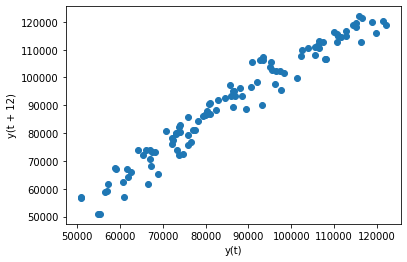

In [74]:
from pandas.plotting import lag_plot
lag_plot(df.TTLCON, lag=12)

Summary: I was dealing with seasonal data of period 12 month. From all tested models the best one was ExponentialSmoothing with $RMSE\approx2515$